In [132]:
import pandas as pd
#import matplotlib.pyplot as plt
#import numpy as np
#from keras.models import Sequential
#from keras.layers import LSTM, Dense
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split

import numpy as np
import tensorflow as tf
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

<h1>Hyperparameters<h1>


In [99]:
#Add here

<h1>Creating DataFrames<h1>

In [100]:
spot_prices = pd.read_csv("spotpriser.csv").set_index("time")
consumption = pd.read_csv("consumption_temp_with_flags.csv").set_index("time")

oslo_consumption = consumption[consumption["location"] == "oslo"]
oslo_consumption = oslo_consumption.merge(spot_prices["oslo"], left_index=True, right_index=True, how="left")
oslo_consumption=oslo_consumption.drop(['location'],axis=1).rename(columns={'oslo':'spot_price'})

stavanger_consumption = consumption[consumption["location"] == "stavanger"]
stavanger_consumption = stavanger_consumption.merge(spot_prices["stavanger"], left_index=True, right_index=True, how="left")
stavanger_consumption=stavanger_consumption.drop(['location'],axis=1).rename(columns={'stavanger':'spot_price'})

trondheim_consumption = consumption[consumption["location"] == "trondheim"]
trondheim_consumption = trondheim_consumption.merge(spot_prices["trondheim"], left_index=True, right_index=True, how="left")
trondheim_consumption=trondheim_consumption.drop(['location'],axis=1).rename(columns={'trondheim':'spot_price'})

tromso_consumption = consumption[consumption["location"] == "tromsø"]
tromso_consumption = tromso_consumption.merge(spot_prices["tromsø"], left_index=True, right_index=True, how="left")
tromso_consumption=tromso_consumption.drop(['location'],axis=1).rename(columns={'tromsø':'spot_price'})

bergen_consumption = consumption[consumption["location"] == "bergen"]
bergen_consumption = bergen_consumption.merge(spot_prices["bergen"], left_index=True, right_index=True, how="left")
bergen_consumption=bergen_consumption.drop(['location'],axis=1).rename(columns={'bergen':'spot_price'})
    

<h1>Feature engineering<h1>

In [101]:
CONSUMPTION_DFS = [oslo_consumption,stavanger_consumption,trondheim_consumption,tromso_consumption,bergen_consumption]

cols_to_standard_normal = ["temperature","delta_temp"]
cols_to_normalize_01 = ["consumption","spot_price"]

for df in CONSUMPTION_DFS:
    df["delta_temp"] = df["temperature"]-df["temperature"].shift(1)
    df["is_holiday"] = df["is_holiday"].astype(int)
    df["is_weekend"] = df["is_weekend"].astype(int)

    for col in cols_to_standard_normal:
        mu, sig = df[col].mean(), df[col].std()
        df[col] = (df[col]-mu)/sig
    for col in cols_to_normalize_01:
        df[col] = (df[col]-df[col].min())/(df[col].max()-df[col].min())
    df = df.iloc[1:,:]


<h1>Splitting datasets<h1>

In [102]:
oslo_with_price = oslo_consumption.dropna()
oslo_no_price = pd.concat([oslo_consumption,oslo_with_price]).drop_duplicates(keep=False).drop(columns=["spot_price"])

stavanger_with_price = stavanger_consumption.dropna()
stavanger_no_price = pd.concat([stavanger_consumption,stavanger_with_price]).drop_duplicates(keep=False).drop(columns=["spot_price"])

trondheim_with_price = trondheim_consumption.dropna()
trondheim_no_price = pd.concat([trondheim_consumption,trondheim_with_price]).drop_duplicates(keep=False).drop(columns=["spot_price"])

tromso_with_price = tromso_consumption.dropna()
tromso_no_price = pd.concat([tromso_consumption,tromso_with_price]).drop_duplicates(keep=False).drop(columns=["spot_price"])

bergen_with_price = bergen_consumption.dropna()
bergen_no_price = pd.concat([bergen_consumption,bergen_with_price]).drop_duplicates(keep=False).drop(columns=["spot_price"])



In [103]:
oslo_with_price

,consumption,temperature,is_holiday,is_weekend,spot_price,delta_temp
time,,,,,,
2022-10-11 00:00:00,0.212632,-0.307026,0,0,0.178110,-0.326610
2022-10-11 01:00:00,0.202627,-0.318428,0,0,0.170600,-0.108693
2022-10-11 02:00:00,0.193783,-0.318428,0,0,0.158543,0.000265
2022-10-11 03:00:00,0.207115,-0.295624,0,0,0.161547,0.218182
2022-10-11 04:00:00,0.246200,-0.261418,0,0,0.176637,0.327139
...,...,...,...,...,...,...
2023-04-02 17:00:00,0.659003,-0.215810,0,1,0.146333,-1.525151
2023-04-02 18:00:00,0.686003,-0.295624,0,1,0.155992,-0.762443
2023-04-02 19:00:00,0.695320,-0.774508,0,1,0.167787,-4.575982


In [104]:
ALL_DFS = [oslo_with_price,oslo_no_price,stavanger_with_price,stavanger_no_price,trondheim_with_price,trondheim_no_price,tromso_with_price,tromso_no_price,bergen_with_price,bergen_no_price]

for i in range(len(ALL_DFS)):
    ALL_DFS[i].index = pd.to_datetime(ALL_DFS[i].index)
    ALL_DFS[i]["hour"] = ALL_DFS[i].index.hour

SettingWithCopyError: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<h1>Making training data<h1>

MAPE LSTM: 17.72745132654364%


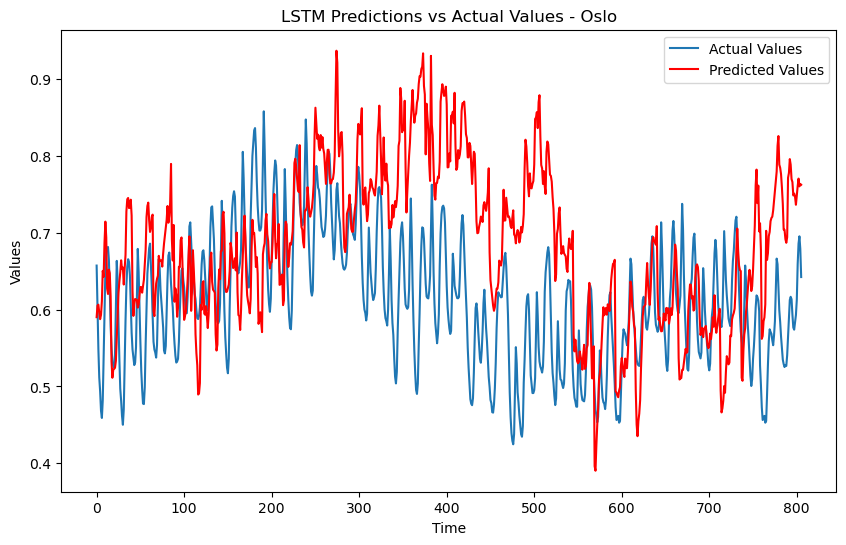

No path specified. Models will be saved in: "AutogluonModels/ag-20231115_124431"
Beginning AutoGluon training ... Time limit = 90s
AutoGluon will save models to "AutogluonModels/ag-20231115_124431"
AutoGluon Version:  0.8.2
Python Version:     3.10.11
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 22.6.0: Fri Sep 15 13:39:54 PDT 2023; root:xnu-8796.141.3.700.8~1/RELEASE_ARM64_T8112
Disk Space Avail:   377.09 GB / 494.38 GB (76.3%)
Train Data Rows:    410
Train Data Columns: 12006
Label Column: target
Preprocessing data ...
/Users/TrymWian/anaconda3/envs/tdt4259/lib/python3.10/site-packages/autogluon/tabular/learner/default_learner.py:215: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipeli

[1000]	valid_set's rmse: 0.0436841


	Ran out of time, early stopping on iteration 1639. Best iteration is:
	[1638]	valid_set's rmse: 0.0436738
	-0.0437	 = Validation score   (-root_mean_squared_error)
	16.72s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ... Training model for up to 18.88s of the -4.99s of remaining time.
	-0.0437	 = Validation score   (-root_mean_squared_error)
	0.02s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 95.08s ... Best model: "WeightedEnsemble_L2"
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/ag-20231115_124431")


                 model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           LightGBMXT  -0.043674       0.020801  16.719729                0.020801          16.719729            1       True          3
1  WeightedEnsemble_L2  -0.043674       0.020972  16.744587                0.000171           0.024858            2       True          4
2       KNeighborsDist  -0.076018       0.043249   1.617020                0.043249           1.617020            1       True          2
3       KNeighborsUnif  -0.077279       0.062113   1.626877                0.062113           1.626877            1       True          1
AutoGluon Leaderboard:
                 model  score_val  pred_time_val   fit_time  \
0           LightGBMXT  -0.043674       0.020801  16.719729   
1  WeightedEnsemble_L2  -0.043674       0.020972  16.744587   
2       KNeighborsDist  -0.076018       0.043249   1.617020   
3       KNeighborsUnif  -0.077279  

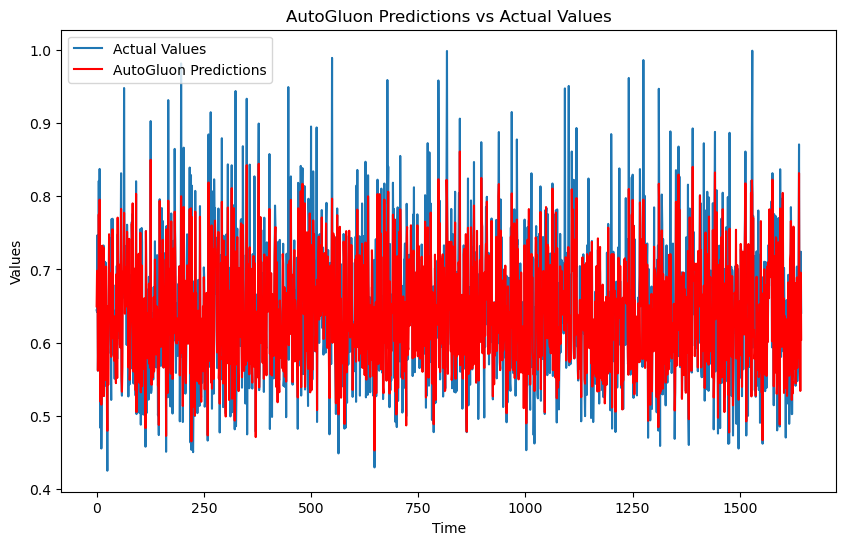

Baseline MAPE: 14.48%


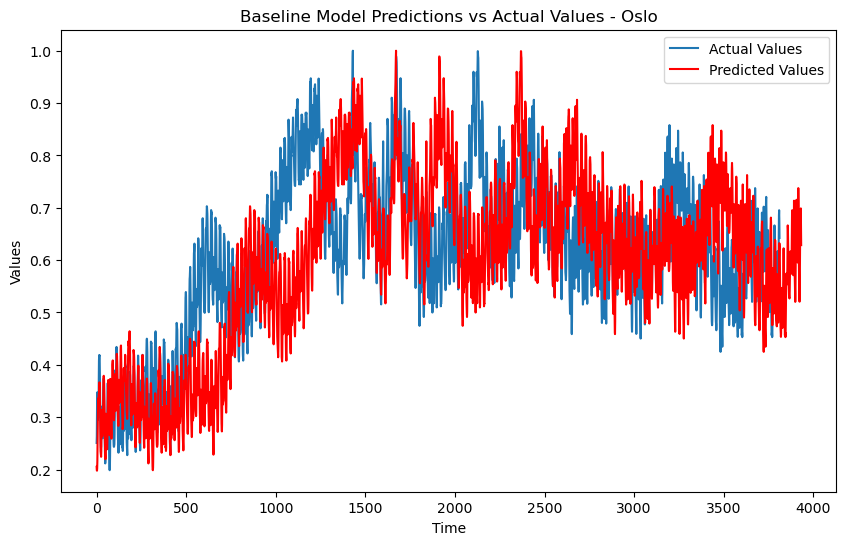

In [163]:
# Seed for reproducibility
np.random.seed(0)

data=oslo_with_price

# Function to create dataset with lags for multiple variables
def create_multivariate_dataset(data, min_lag=1, max_lag=3):
    X, y = [], []
    for i in range(max_lag, len(data)):
        lagged_data = data.iloc[i-max_lag:i-min_lag+1, 1:]  # Shape: [time_steps, num_predictors]
        X.append(lagged_data.values)
        y.append(data.iloc[i, 0])  # Target variable (Sales)
    return np.array(X), np.array(y)

"""# Hyperparameter ranges
min_lag_values = [120]
max_lag_values = [2120]
lstm_units_values = [25]

# k-Fold for validation
k = 5
kf = KFold(n_splits=k, shuffle=False)

# Grid Search
best_mape = float('inf')
best_hyperparams = None

print("Min Max Units || MAPE")
for min_lag in min_lag_values:
    for max_lag in max_lag_values:
        for lstm_units in lstm_units_values:
            if max_lag > min_lag:
                print(f"{min_lag}   {max_lag}   {lstm_units}   ||",end="")
                X, y = create_multivariate_dataset(data, min_lag, max_lag)
                mape_values = []

                for train_index, val_index in kf.split(X):
                    X_train, X_val = X[train_index], X[val_index]
                    y_train, y_val = y[train_index], y[val_index]

                    # Building and Training the LSTM Model
                    model = Sequential()
                    model.add(LSTM(lstm_units, activation='relu', input_shape=(X.shape[1], X.shape[2])))
                    model.add(Dense(1))
                    model.compile(optimizer='adam', loss='mse')

                    # Training the model
                    model.fit(X_train, y_train, epochs=5, verbose=0)

                    # Making predictions
                    y_pred = model.predict(X_val, verbose=0).flatten()

                    # Calculating MAPE for the fold
                    mape = np.mean(np.abs((y_val - y_pred) / y_val)) * 100
                    mape_values.append(mape)

                # Averaging MAPE across all folds
                average_mape = np.mean(mape_values)
                print(f" {average_mape}")
                # Update best hyperparameters if current MAPE is lower
                if best_hyperparams == None:
                    best_hyperparams = (min_lag, max_lag, lstm_units)
                if best_mape == float('inf'):
                    best_mape = average_mape
                if average_mape < best_mape:
                    best_mape = average_mape
                    best_hyperparams = (min_lag, max_lag, lstm_units)

print(f'Best Hyperparameters: min_lag={best_hyperparams[0]}, max_lag={best_hyperparams[1]}, LSTM Units={best_hyperparams[2]}')
print(f'Best MAPE: {best_mape}%')
"""

# Store the best model's predictions and actual values
#best_predictions = []
#best_actuals = []

# Retrain the best model
#X, y = create_multivariate_dataset(data, *best_hyperparams[:2])
X, y = create_multivariate_dataset(data, 120,144)
kf = KFold(n_splits=k, shuffle=False)

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Building and Training the LSTM Model with best hyperparameters
    model = Sequential()
    #model.add(LSTM(best_hyperparams[2], activation='relu', input_shape=(X.shape[1], X.shape[2])))
    model.add(LSTM(25, activation='relu', input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Training the model
    model.fit(X_train, y_train, epochs=5, verbose=0)

    # Making predictions
    y_pred = model.predict(X_val, verbose=0).flatten()

    #best_predictions.extend(y_pred)
    #best_actuals.extend(y_val)

mape = np.mean(np.abs((y_val - y_pred) / y_val)) * 100
print(f'MAPE LSTM: {mape}%')

# Plot the predictions against the actual values
plt.figure(figsize=(10, 6))
plt.plot(y_val, label='Actual Values')
plt.plot(y_pred, label='Predicted Values', color='red')
plt.title('LSTM Predictions vs Actual Values - Oslo')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()


def create_tabular_dataset(data, min_lag, max_lag):
    df = pd.DataFrame(data)
    X, y = [], []
    for i in range(max_lag, len(df)):
        lagged_data = df.iloc[i - max_lag:i - min_lag + 1, 1:]  # Shape: [time_steps, num_predictors]
        X.append(lagged_data.values.flatten())
        y.append(df.iloc[i, 0])  # Target variable (Sales)
    return pd.DataFrame(X), pd.Series(y)

# Convert the dataset to tabular format
X, y = create_tabular_dataset(data, 120, 2120)

# Merge the features and target for AutoGluon
autogluon_data = pd.concat([y, X], axis=1)
autogluon_data.columns = ['target'] + [f'feature_{i}' for i in range(X.shape[1])]

# Define the problem type (regression in this case)
problem_type = 'regression'

# Initialize AutoGluon TabularPredictor
predictor = TabularPredictor(label='target', problem_type=problem_type)

# Split the data into train and validation sets
train_data, val_data = train_test_split(autogluon_data, shuffle=True, test_size=0.80, random_state=42)

# Fit AutoGluon model
predictor.fit(train_data, time_limit=90)  # You can adjust the time_limit parameter

# Get predictions on the validation set
autogluon_predictions = predictor.predict(val_data.drop(columns=['target'])).values

leaderboard = predictor.leaderboard()
print("AutoGluon Leaderboard:")
print(leaderboard)

# Calculate MAPE for AutoGluon model
autogluon_mape = np.mean(np.abs((val_data['target'].values - autogluon_predictions) / val_data['target'].values)) * 100

print(f'AutoGluon MAPE: {autogluon_mape:.2f}%')

# Plot the predictions against the actual values
plt.figure(figsize=(10, 6))
plt.plot(val_data['target'].values, label='Actual Values')
plt.plot(autogluon_predictions, label='AutoGluon Predictions', color='red')
plt.title('AutoGluon Predictions vs Actual Values')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()


# Function to create a simple baseline model
def baseline_model(y, min_lag):
    baseline_predictions = []
    baseline_predictions = y[:-min_lag]
    baseline_mape = np.mean(np.abs((y[min_lag:] - baseline_predictions) / y[min_lag:])) * 100
    return baseline_predictions, baseline_mape

def baseline_avg_model(y, min_lag, max_lag):
    baseline_predictions = []
    for i in range(max_lag, len(y)-min_lag):
        average_value = np.mean(y[i - max_lag:i - min_lag])
        baseline_predictions.append(average_value)
    baseline_mape = np.mean(np.abs((y[max_lag+min_lag:] - baseline_predictions) / y[max_lag+min_lag:])) * 100
    return baseline_predictions, baseline_mape

def improved_model(y, min_lag, max_lag):
    baseline_predictions = []
    for i in range(max_lag, len(y)-min_lag):
        next_value = y[i - min_lag]*1.01 - y[i - min_lag - 1]*0.007 - y[i - min_lag - 2]*0.003
        baseline_predictions.append(next_value)
    baseline_mape = np.mean(np.abs((y[max_lag+min_lag:] - baseline_predictions) / y[max_lag+min_lag:])) * 100
    return baseline_predictions, baseline_mape

def linreg_baseline_model(y, min_lag, max_lag):
    baseline_predictions = []

    # k-Fold for validation
    k = 5
    kf = KFold(n_splits=k, shuffle=False)
    X_train, y_train = train_test_split(X,y)

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Building and Training the LSTM Model
        model = LinearRegression()
        
        # Training the model
        model.fit(X_train, y_train)

        # Making predictions
        y_pred = model.predict(X_val).flatten()

        # Calculating MAPE for the fold
        mape = np.mean(np.abs((y_val - y_pred) / y_val)) * 100
        mape_values.append(mape)

        # Averaging MAPE across all folds
        average_mape = np.mean(mape_values)
        print(f" {average_mape}")
        # Update best hyperparameters if current MAPE is lower
        if best_hyperparams == None:
            best_hyperparams = (min_lag, max_lag, lstm_units)
        if best_mape == float('inf'):
            best_mape = average_mape
        if average_mape < best_mape:
            best_mape = average_mape
            best_hyperparams = (min_lag, max_lag, lstm_units)

    print(f'Best Hyperparameters: min_lag={best_hyperparams[0]}, max_lag={best_hyperparams[1]}, LSTM Units={best_hyperparams[2]}')
    print(f'Best MAPE: {best_mape}%')



# Calculate the baseline predictions
X, y = create_multivariate_dataset(data, min_lag, max_lag)
min_lag = 120
max_lag = 121
baseline_predictions, baseline_mape = baseline_model(y,min_lag)

# Print the baseline MAPE
print(f'Baseline MAPE: {baseline_mape:.2f}%')


# Plot the predictions against the actual values
plt.figure(figsize=(10, 6))
plt.plot(y[max_lag+min_lag:], label='Actual Values')
plt.plot(baseline_predictions, label='Predicted Values', color='red')
plt.title('Baseline Model Predictions vs Actual Values - Oslo')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()




MAPE LSTM: 15.230140669586817%


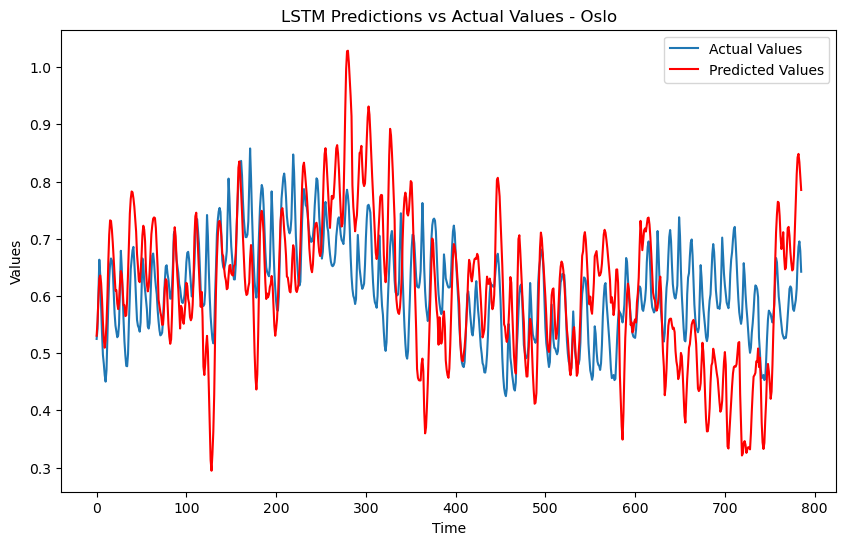

In [159]:
# Seed for reproducibility
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)


data=oslo_with_price

# Function to create dataset with lags for multiple variables
def create_multivariate_dataset(data, min_lag, max_lag):
    X, y = [], []
    for i in range(max_lag, len(data)):
        lagged_data = data.iloc[i-max_lag:i-min_lag+1, 1:]
        X.append(lagged_data.values)
        y.append(data.iloc[i, 0])
    return np.array(X), np.array(y)

X, y = create_multivariate_dataset(data, 120,240)
kf = KFold(n_splits=k, shuffle=False)

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Building and Training the LSTM Model with best hyperparameters
    model = Sequential()
    model.add(LSTM(25, activation='relu', input_shape=(X.shape[1], X.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Training the model
    model.fit(X_train, y_train, epochs=1000, verbose=0)

    # Making predictions
    y_pred = model.predict(X_val, verbose=0).flatten()

mape = np.mean(np.abs((y_val - y_pred) / y_val)) * 100
print(f'MAPE LSTM: {mape}%')

# Plot the predictions against the actual values
plt.figure(figsize=(10, 6))
plt.plot(y_val, label='Actual Values')
plt.plot(y_pred, label='Predicted Values', color='red')
plt.title('LSTM Predictions vs Actual Values - Oslo')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

In [166]:
baseline_predictions = []

# k-Fold for validation
k = 5
kf = KFold(n_splits=k, shuffle=False)

def create_lagged_dataset(data, min_lag=1, max_lag=3):
    X, y = [], []
    for lag in range(min_lag, max_lag+1):
        for col in data.columns:
            data[f"{col}_L{lag}"] = data.shift(lag)[col]
    return np.array(X), np.array(y)

for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Building and Training the LSTM Model
    model = LinearRegression()
    
    # Training the model
    model.fit(X_train, y_train)

    # Making predictions
    y_pred = model.predict(X_val).flatten()

    # Calculating MAPE for the fold
    mape = np.mean(np.abs((y_val - y_pred) / y_val)) * 100
    mape_values.append(mape)

    # Averaging MAPE across all folds
    average_mape = np.mean(mape_values)
    print(f" {average_mape}")
    # Update best hyperparameters if current MAPE is lower
    if best_hyperparams == None:
        best_hyperparams = (min_lag, max_lag, lstm_units)
    if best_mape == float('inf'):
        best_mape = average_mape
    if average_mape < best_mape:
        best_mape = average_mape
        best_hyperparams = (min_lag, max_lag, lstm_units)

print(f'Best Hyperparameters: min_lag={best_hyperparams[0]}, max_lag={best_hyperparams[1]}, LSTM Units={best_hyperparams[2]}')
print(f'Best MAPE: {best_mape}%')

ValueError: Found array with dim 3. LinearRegression expected <= 2.